In [1]:
%matplotlib inline

from glnem import GLNEM
from glnem.datasets import load_banana_trade

## Check Assumption 2 [rank($\bar{X}$) = $p$]

In [2]:
from glnem.network_utils import node_averaged_rank

Y, X, countries = load_banana_trade(max_nodes=75, include_diag=True)

# there are 5 covariates plus an intercept, so p = 6
node_averaged_rank(X)

6

## Fit a Tweedie GLNEM (d = 10)

In [3]:
# we fit the tweedie GLNEM on the sub-diagonal entries
Y, X, countries = load_banana_trade(max_nodes=75, include_diag=False)

In [ ]:
model = GLNEM(family='tweedie', link='log', n_features=10, random_state=42)
model.sample(Y, X=X, n_warmup=7500, n_samples=15000)

In [4]:
model.print_summary(proba=0.95)

WAIC: 15628.902

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
          X1     -1.04      0.10     -1.03     -1.22     -0.84   3393.86      1.00
          X2      0.30      0.04      0.30      0.22      0.37   2681.60      1.00
          X3      1.02      0.32      1.02      0.42      1.65   8890.91      1.00
          X4      1.78      0.31      1.78      1.15      2.37   4677.19      1.00
          X5      2.64      0.20      2.64      2.25      3.04   8060.62      1.00
  dispersion     34.53      1.49     34.51     31.68     37.50    459.55      1.01
   intercept     -0.89      0.82     -0.88     -2.56      0.67   1343.79      1.01
   lambda[0]     93.15     15.31     91.67     66.52    124.65    653.86      1.01
   lambda[1]   -229.82     10.54   -229.42   -249.89   -208.83   1164.78      1.00
   lambda[2]     70.41      7.52     70.67     56.53     84.60   2187.42      1.01
   lambda[3]    -56.67     11.89    -56.35    -79.01    -38.26   4417.

## Diagnostic Plots (Figure S15)

<IPython.core.display.Javascript object>


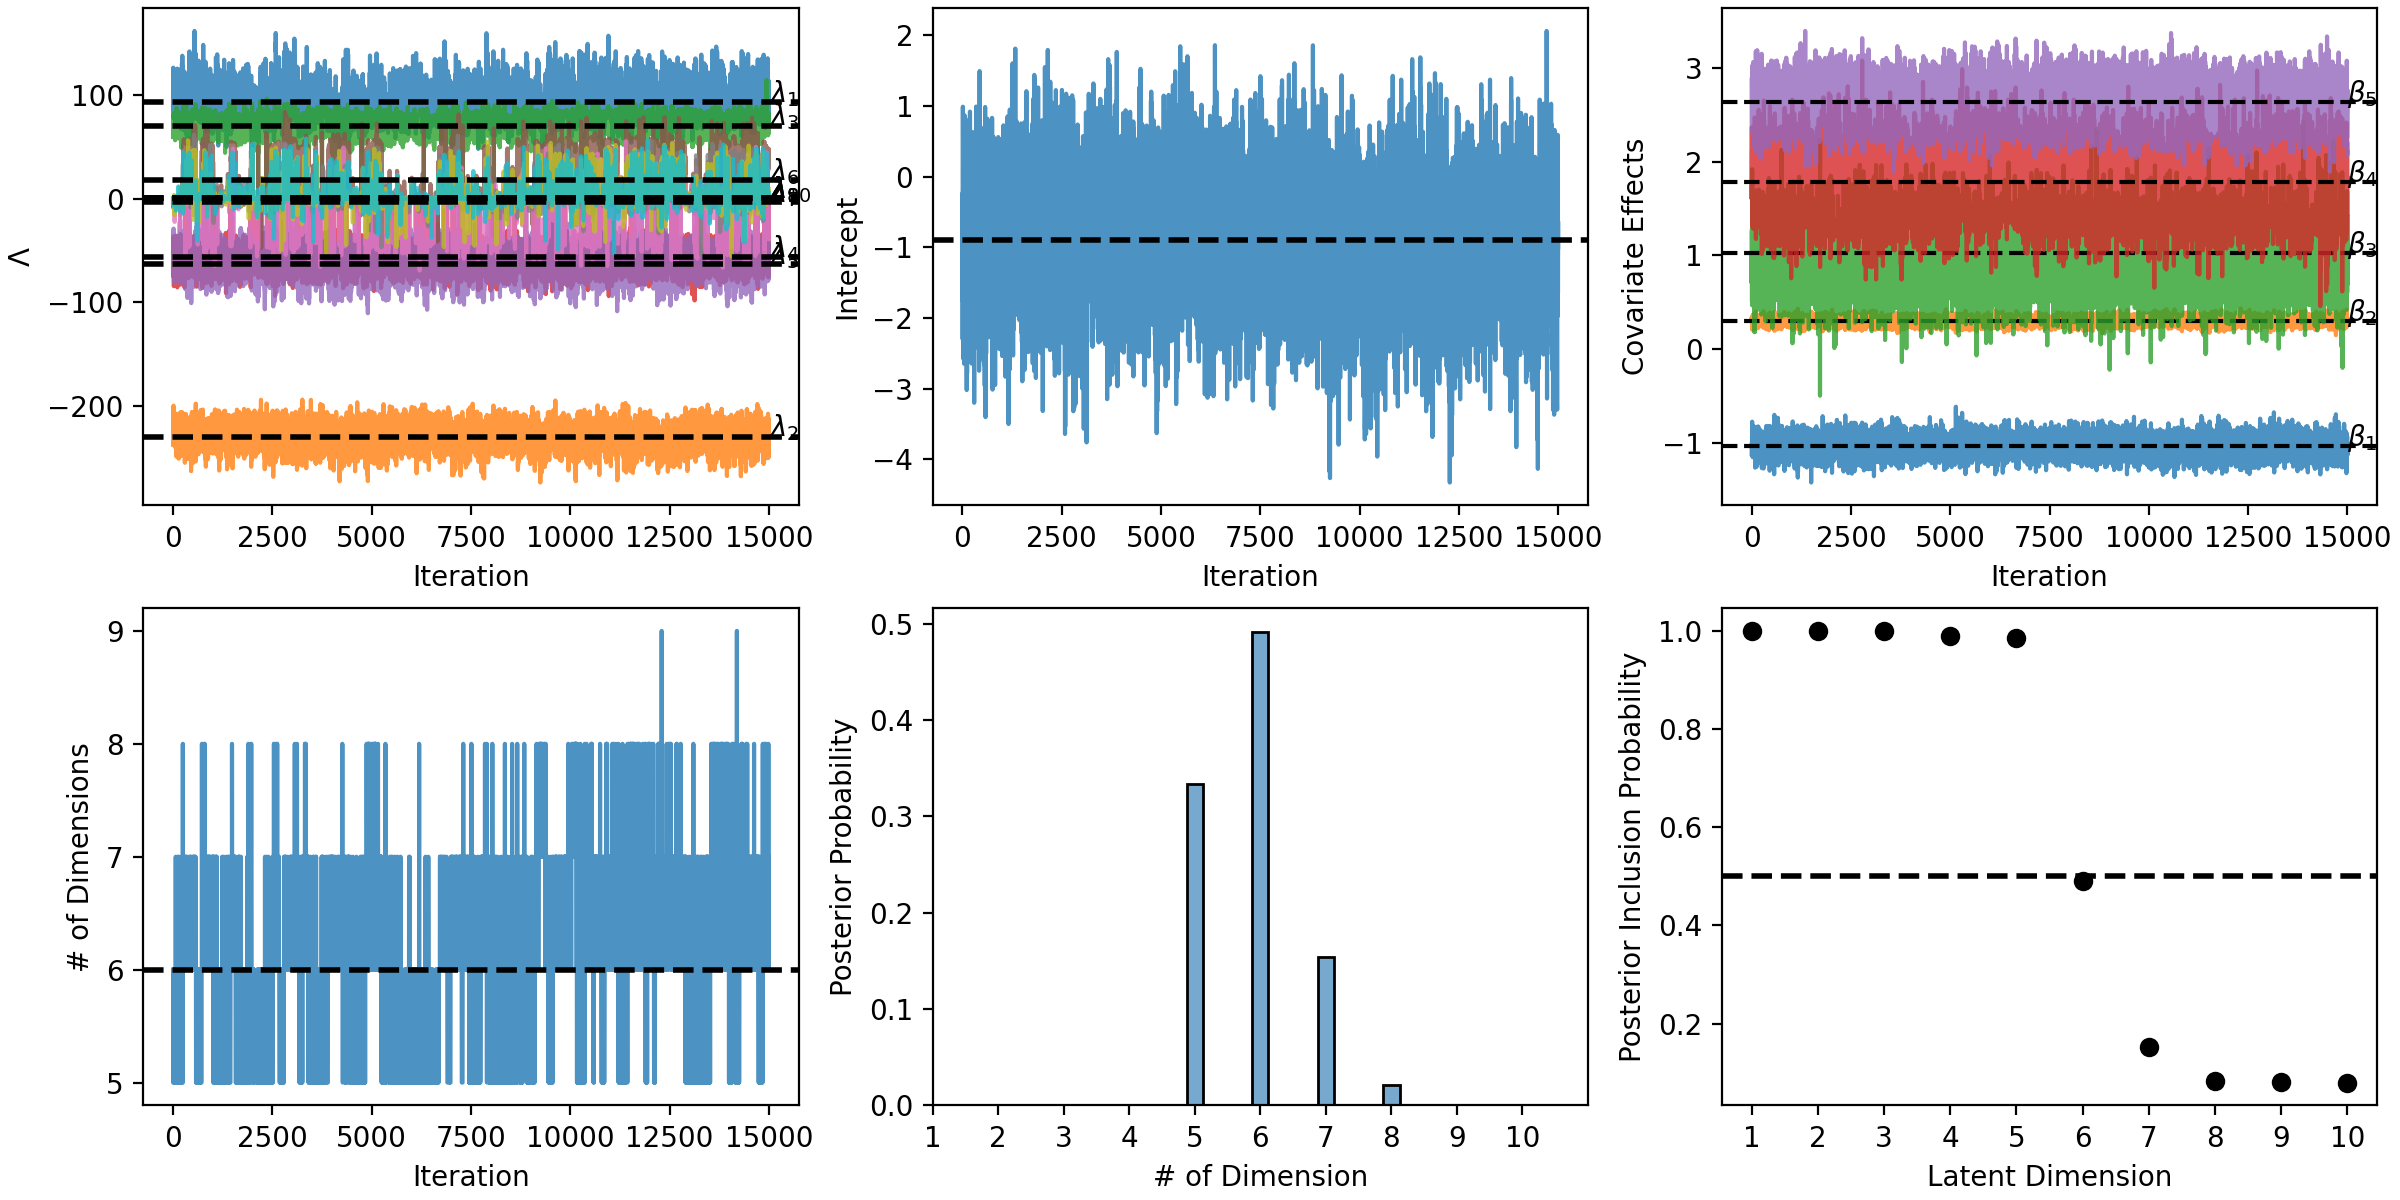

{'A': <Axes: label='A', xlabel='Iteration', ylabel='$\\Lambda$'>,
 'B': <Axes: label='B', xlabel='Iteration', ylabel='Intercept'>,
 'C': <Axes: label='C', xlabel='Iteration', ylabel='Covariate Effects'>,
 'D': <Axes: label='D', xlabel='Iteration', ylabel='# of Dimensions'>,
 'E': <Axes: label='E', xlabel='# of Dimension', ylabel='Posterior Probability'>,
 'F': <Axes: label='F', xlabel='Latent Dimension', ylabel='Posterior Inclusion Probability'>}

In [6]:
model.plot(Y_obs=Y, include_diagnostics=False, figsize=(12,6))

## Node-Averaged Covariate Effects (Figure S14)

<IPython.core.display.Javascript object>


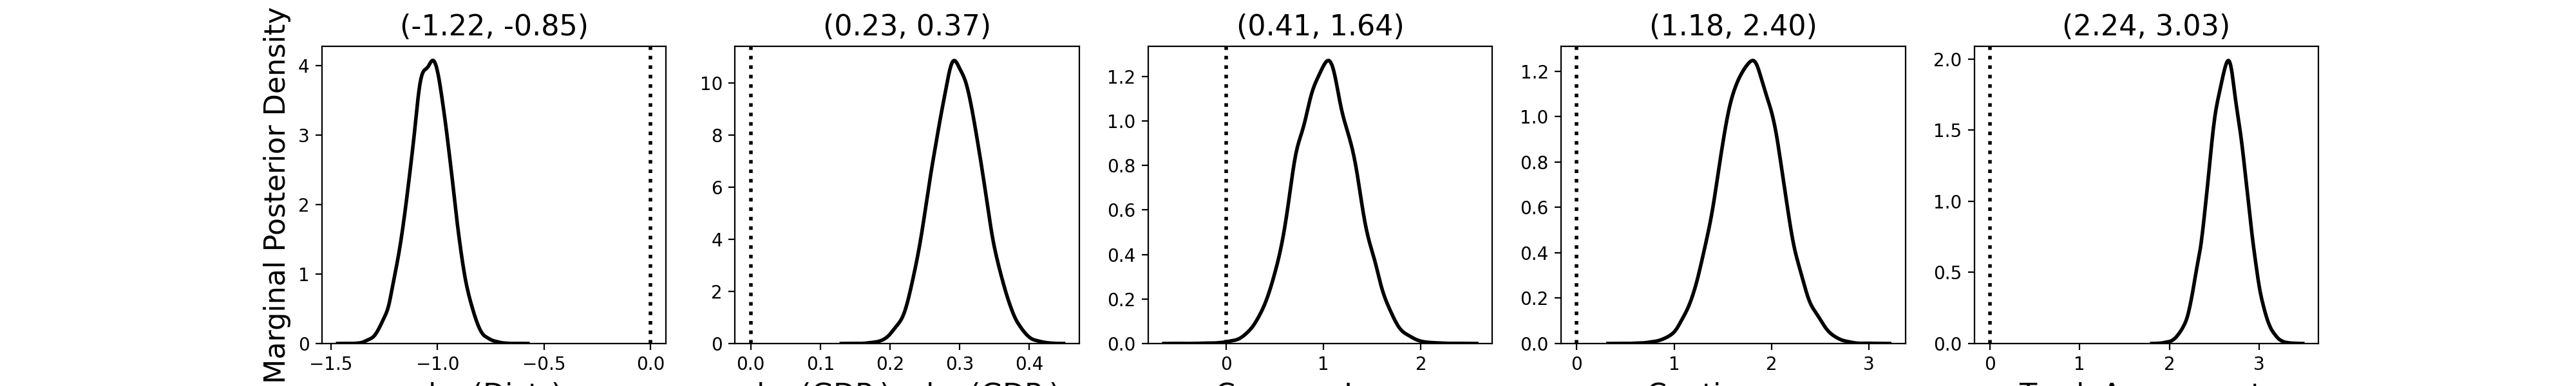

In [9]:
import seaborn as sns

fig, ax = plt.subplots(ncols=5, figsize=(20, 3))

labels = {
    'X1': r"$\log($Dist$_{ij})$", 
    'X2': r"$\log($GDP$_{i}) + \log($GDP$_{j})$",
    'X3': r"CommonLang$_{ij}$",
    'X4': r"Contiguous$_{ij}$",
    'X5': r"TradeAgreement$_{ij}$",
}

colors = ['steelblue', 'darkorange']
linestyle = ['solid', 'dashed']
glnem = model
for k, var in enumerate(['X1', 'X2', 'X3', 'X4', 'X5']):
    
    interval = list(np.quantile(
        glnem.samples_[var], q=[0.025, 0.975]))
    mean = glnem.samples_[var].mean()
    sns.kdeplot(glnem.samples_[var], c='k', ax=ax[k],
                linestyle='-', lw=2)

    ax[k].set_title(f"({interval[0]:.2f}, {interval[1]:.2f})",
                    fontsize=16)
    ax[k].axvline(0, c='k', linestyle='dotted', lw=2)
    ax[k].set_xlabel(labels[var], fontsize=16)
    ax[k].set_ylabel('Marginal Posterior Density', fontsize=16)
    if k > 0:
        ax[k].set_ylabel('')

## Latent Space (Figure 3)

<IPython.core.display.Javascript object>


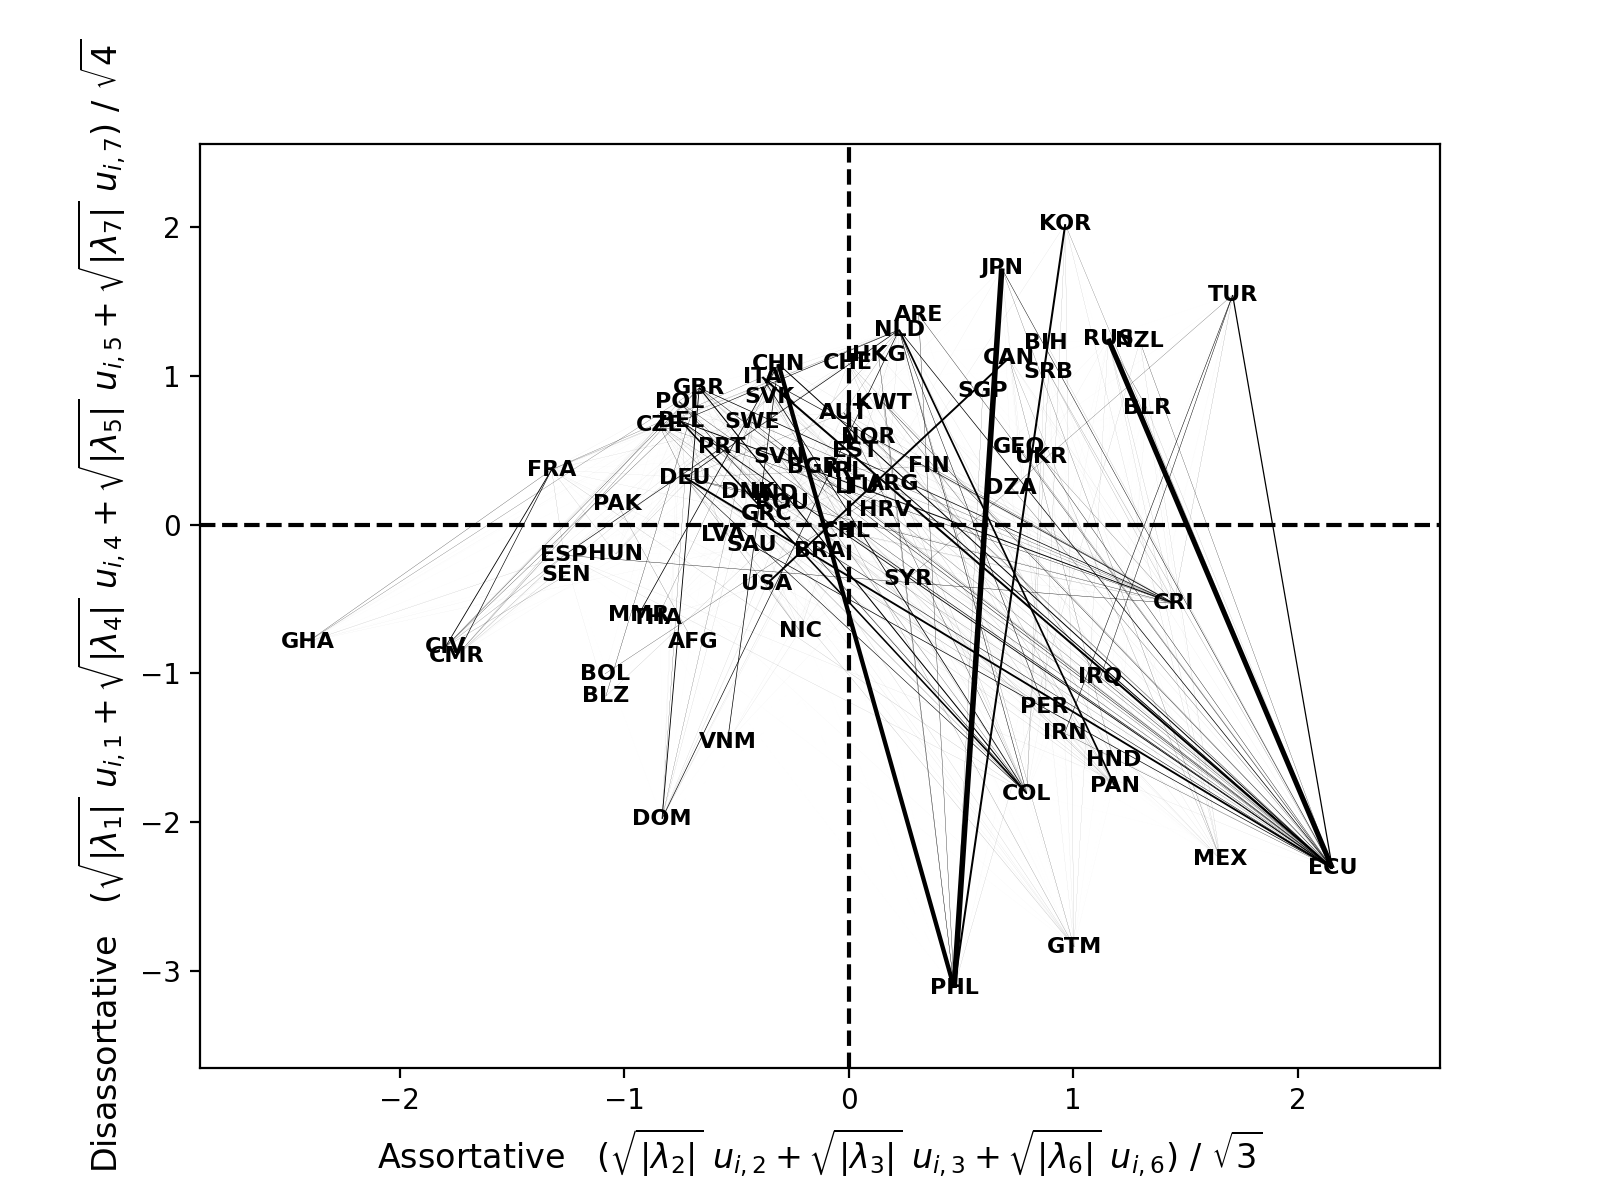

Text(0, 0.5, 'Disassortative   $(\\sqrt{|\\lambda_1|} \\ u_{i,1} + \\sqrt{|\\lambda_4|} \\ u_{i,4} + \\sqrt{|\\lambda_5|} \\ u_{i,5} + \\sqrt{|\\lambda_7|} \\ u_{i,7})\\ / \\ \\sqrt{4}$')

In [9]:
import networkx as nx


names = countries.ravel()
g = nx.from_numpy_array(Y)
g = nx.relabel_nodes(g, {k : names[k] for k in range(Y.shape[0])})
d = Y.sum(axis=0)
edges, weights = zip(*nx.get_edge_attributes(g, 'weight').items())
med_weight = np.median(weights)
weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

U = model.U_ * np.sqrt(np.abs(model.lambda_))


fig, ax = plt.subplots(figsize=(8, 6))

u = np.c_[
    -(U[:, 0] + U[:, 2] + U[:, 5])/np.sqrt(3), 
    (U[:, 1] + U[:, 3] + U[:, 4] + U[:, 6])/np.sqrt(4)]
mag = np.sum(u ** 2, axis=1)
ids_text = np.where(mag > 0)[0]#np.quantile(mag, q=0.0))[0]

labels = {names[k] : names[k] if k in ids_text else '' for k in range(Y.shape[0])}
pos = {names[k] : u[k] for k in range(Y.shape[0])}
sizes = [0 if k in ids_text else 150 * d[k]/np.max(d) for k in range(Y.shape[0])]
nx.draw_networkx(g, pos, node_size=sizes, 
                 node_color='k',
                 edge_color='k', width=2 * weights, 
                 labels=labels, with_labels=True, font_size=8, font_weight='bold',
                 edgecolors=['k' if k  in ids_text else 'k' for k in range(Y.shape[0])],
                 ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel(r'Assortative   $(\sqrt{|\lambda_2|} \ u_{i,2} + \sqrt{|\lambda_3|} \ u_{i,3} + \sqrt{|\lambda_6|} \ u_{i,6})\ / \ \sqrt{3}$',
             fontsize=12)
ax.set_ylabel(r'Disassortative   $(\sqrt{|\lambda_1|} \ u_{i,1} + \sqrt{|\lambda_4|} \ u_{i,4} + \sqrt{|\lambda_5|} \ u_{i,5} + \sqrt{|\lambda_7|} \ u_{i,7})\ / \ \sqrt{4}$',
             fontsize=12)

# Sensitivity to Truncation Level $d$

## Tweedie GLNEM (d = 12)

In [18]:
model_d12 = GLNEM(family='tweedie', link='log', n_features=12, random_state=42)
model_d12.sample(Y, X=X, n_warmup=7500, n_samples=15000)

sample: 100%|███████████████████████████████████| 22500/22500 [1:00:24<00:00,  6.21it/s, 127 steps of size 2.78e-02. acc. prob=0.90]


## Tweedie GLNEM (d = 8)

In [21]:
model_d8 = GLNEM(family='tweedie', link='log', n_features=8, random_state=42)
model_d8.sample(Y, X=X, n_warmup=7500, n_samples=15000)

sample: 100%|█████████████████████████████████████| 22500/22500 [42:27<00:00,  8.83it/s, 127 steps of size 2.45e-02. acc. prob=0.92]


## Node-Average Effects Comparison (Figure S7)

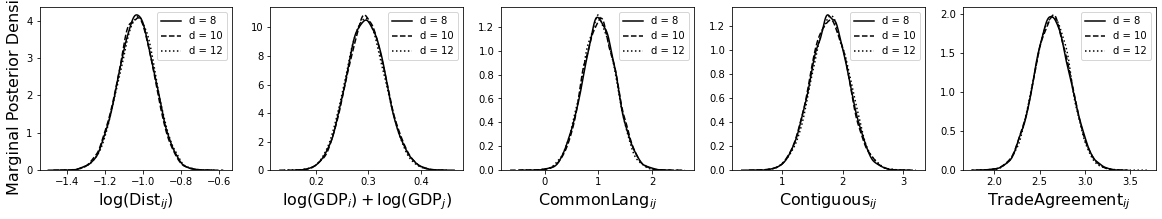

In [101]:
labels = {
    'X1': r"$\log($Dist$_{ij})$", 
    'X2': r"$\log($GDP$_{i}) + \log($GDP$_{j})$",
    'X3': r"CommonLang$_{ij}$",
    'X4': r"Contiguous$_{ij}$",
    'X5': r"TradeAgreement$_{ij}$",
}

fig, ax = plt.subplots(ncols=5, figsize=(20, 3))

for k in range(5):
    sns.kdeplot(model_d8.samples_[f'X{k+1}'], c='k', linestyle='-', ax=ax[k], label='d = 8')
    sns.kdeplot(model.samples_[f'X{k+1}'], c='k', linestyle='--', ax=ax[k], label='d = 10')
    sns.kdeplot(model_d12.samples_[f'X{k+1}'], c='k', linestyle=':', ax=ax[k], label='d = 12')
    
    #ax[k].axvline(0, c='k', linestyle='dotted', lw=2)
    ax[k].set_xlabel(labels[f'X{k+1}'], fontsize=16)
    ax[k].set_ylabel('Marginal Posterior Density', fontsize=16)
    if k > 0:
        ax[k].set_ylabel('')
    ax[k].legend()

## Dimension Posterior Comparison (Figure S8)

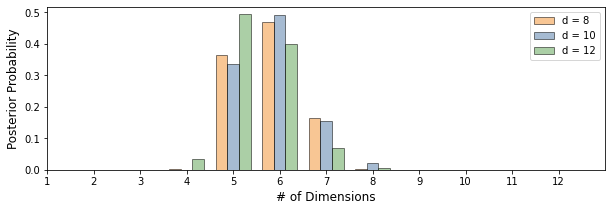

In [102]:
fig, ax = plt.subplots(figsize=(10,3))

count_d10 = np.bincount(model.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d12 = np.bincount(model_d12.samples_['z'].sum(axis=1), minlength=12)[1:]
count_d8 = np.bincount(model_d8.samples_['z'].sum(axis=1), minlength=12)[1:]

ax.bar(np.arange(1, 12)-0.25, count_d8/count_d8.sum(),
       width=0.25, alpha=0.5, color='#f28e2b', edgecolor='k', label='d = 8')
ax.bar(np.arange(1, 12), count_d10/count_d10.sum(), 
       color='#4e79a7', width=0.25, alpha=0.5, edgecolor='k', label='d = 10')
ax.bar(np.arange(1, 12)+0.25, count_d12/count_d12.sum(), 
       color='#59a14f', width=0.25, alpha=0.5, edgecolor='k', label='d = 12')
ax.set_xlim(1, 13)
ax.set_xticks(np.arange(1, 13))
ax.set_xlabel('# of Dimensions', fontsize=12)
ax.set_ylabel('Posterior Probability', fontsize=12)

ax.legend()